# Annotated Pylint Radon

Correlation:
- join with objectives score
- compute length
- compute inv_inf score

Comparison
- direct/indirect

In [25]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("""
    SELECT ps.conversation_id, ps. message_id, ps.message_text, ps.gender, ps.user_id, ps.model_version,  ps.radon_complexity,ps.radon_maintainability_index, ps.radon_loc, ps.radon_sloc, ps.radon_lloc, ps.radon_comments, ps.pylint_score,
           ap.maj_objectives_score, ap.maj_communication_score,
           p.conversational,
           cp.can_you_question, cp.i_statement, cp.unpersonal_command, cp.you_command, cp.we_command, cp.unpersonal_question, cp.i_question, cp.we_question,
        iis.involved, iis.informational, iis.inv_inf
    FROM pylint_scores ps
    JOIN annotated_prompts ap ON ps.message_id = ap.message_id
    JOIN manually_split_prompts p ON ps.message_id = p.message_id
    JOIN categorized_prompts cp ON ps.message_id = cp.message_id
    JOIN inv_inf_scores iis ON ps.message_id = iis.message_id;
""", conn)

code

,conversation_id,message_id,message_text,gender,user_id,model_version,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,...,i_statement,unpersonal_command,you_command,we_command,unpersonal_question,i_question,we_question,involved,informational,inv_inf
0,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,0.000000,100.000000,19.0,8.0,...,1,0,0,0,0,1,0,18.181818,18.181818,1.000000
1,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,chatgpt-4o-latest,0.000000,100.000000,22.0,9.0,...,1,0,0,0,0,0,0,29.411765,14.705882,2.000000
2,10,57,"as a NLP and LLM researcher, I am recently dow...",Non-binary,30,chatgpt-4o-latest,NaN,NaN,36.0,32.0,...,1,0,0,0,0,0,0,16.304348,19.565217,0.833333
3,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,chatgpt-4o-latest,6.000000,76.810412,62.0,38.0,...,0,0,1,0,0,0,0,15.384615,20.512821,0.750000
4,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,chatgpt-4o-latest,1.333333,90.912037,21.0,16.0,...,0,0,0,0,1,0,0,15.151515,18.181818,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,deepseek-chat,5.000000,87.789161,30.0,22.0,...,0,0,0,0,0,0,0,25.000000,16.666667,1.500000
491,72,1534,can you write me some python code to count the...,Woman (cisgender),11,deepseek-chat,1.000000,82.315095,25.0,17.0,...,0,0,0,0,0,0,0,18.750000,18.750000,1.000000
492,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,deepseek-chat,0.000000,100.000000,1.0,1.0,...,1,0,0,0,0,0,1,16.666667,27.777778,0.600000
493,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,deepseek-chat,0.000000,100.000000,21.0,14.0,...,1,0,0,0,0,0,0,16.666667,20.000000,0.833333


In [26]:
import pandas as pd

# List of columns to aggregate using mean and std
agg_cols = [
    "radon_complexity",
    "radon_maintainability_index",
    "radon_loc",
    "radon_sloc",
    "radon_lloc",
    "radon_comments",
    "pylint_score"
]

# Define aggregation dictionary for mean and std, ignore NaNs automatically
agg_dict = {}
for col in agg_cols:
    agg_dict[col] = ['mean', 'std']

# Group by the required columns
group_cols = [
    "conversation_id",
    "message_id",
    "message_text",
    "conversational",
    "gender",
    "user_id",
    "model_version",
    "maj_objectives_score",
    "maj_communication_score",
    "can_you_question",
    "i_statement",
    "unpersonal_command",
    "you_command",
    "we_command",
    "unpersonal_question",
    "i_question",
    "we_question",
    "informational",
    "involved",
    "inv_inf"
]

# Perform aggregation
agg_df = (
    code
    .groupby(group_cols, dropna=False)
    .agg(agg_dict)
    .reset_index()
)

# Flatten column multi-index
agg_df.columns = [
    f"{col if stat == '' else stat + '_' + col}" if stat != '' else col
    for col, stat in agg_df.columns.to_flat_index()
]

# Move mean_/std_ to correct suffix format: mean_colname, std_colname
agg_df = agg_df.rename(columns={f"mean_{col}": f"mean_{col}" for col in agg_cols})
agg_df = agg_df.rename(columns={f"std_{col}": f"std_{col}" for col in agg_cols})

agg_df


,conversation_id,message_id,message_text,conversational,gender,user_id,model_version,maj_objectives_score,maj_communication_score,can_you_question,...,mean_radon_loc,std_radon_loc,mean_radon_sloc,std_radon_sloc,mean_radon_lloc,std_radon_lloc,mean_radon_comments,std_radon_comments,mean_pylint_score,std_pylint_score
0,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,5,6,0,...,18.000000,1.732051,8.000000,0.000000,9.000000,0.000000,4.666667,0.577350,10.000000,0.000000
1,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,5,6,0,...,24.333333,2.309401,10.666667,0.577350,8.333333,0.577350,8.666667,1.527525,9.166667,0.721688
2,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,5,6,0,...,15.000000,1.000000,7.666667,0.577350,7.000000,1.000000,3.666667,0.577350,10.000000,0.000000
3,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,5,6,0,...,15.000000,0.000000,7.000000,0.000000,7.000000,0.000000,5.000000,0.000000,8.570000,0.000000
4,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,5,6,0,...,18.333333,2.081666,8.333333,0.577350,9.333333,0.577350,4.666667,0.577350,7.776667,3.850926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,claude-sonnet-4-20250514,3,5,0,...,9.666667,4.041452,6.333333,2.886751,4.333333,1.154701,3.666667,2.309401,10.000000,0.000000
163,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,deepseek-chat,3,5,0,...,10.000000,0.000000,4.000000,0.000000,4.000000,0.000000,4.000000,0.000000,10.000000,0.000000
164,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-4.1-2025-04-14,3,5,0,...,7.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.333333,0.577350,10.000000,0.000000
165,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-5-chat-latest,3,5,0,...,11.000000,4.358899,6.000000,2.645751,7.000000,4.358899,2.333333,0.577350,10.000000,0.000000


In [27]:
agg_df["length_message_text_chars"] = agg_df["message_text"].astype(str).apply(len)
agg_df["length_conversational_chars"] = agg_df["conversational"].astype(str).apply(len)

# Word count
agg_df["length_message_text_words"] = agg_df["message_text"].astype(str).apply(lambda x: len(x.split()))
agg_df["length_conversational_words"] = agg_df["conversational"].astype(str).apply(lambda x: len(x.split()))


In [28]:
models = ["chatgpt-4o-latest", "o3-2025-04-16", "gpt-5-chat-latest", "gpt-4.1-2025-04-14", "deepseek-chat", "claude-3-7-sonnet-20250219", "claude-sonnet-4-20250514"]

In [33]:
agg_df

,conversation_id,message_id,message_text,conversational,gender,user_id,model_version,maj_objectives_score,maj_communication_score,can_you_question,...,mean_radon_lloc,std_radon_lloc,mean_radon_comments,std_radon_comments,mean_pylint_score,std_pylint_score,length_message_text_chars,length_conversational_chars,length_message_text_words,length_conversational_words
0,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,5,6,0,...,9.000000,0.000000,4.666667,0.577350,10.000000,0.000000,191,191,36,36
1,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,5,6,0,...,8.333333,0.577350,8.666667,1.527525,9.166667,0.721688,191,191,36,36
2,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,5,6,0,...,7.000000,1.000000,3.666667,0.577350,10.000000,0.000000,191,191,36,36
3,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,5,6,0,...,7.000000,0.000000,5.000000,0.000000,8.570000,0.000000,191,191,36,36
4,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,5,6,0,...,9.333333,0.577350,4.666667,0.577350,7.776667,3.850926,191,191,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,claude-sonnet-4-20250514,3,5,0,...,4.333333,1.154701,3.666667,2.309401,10.000000,0.000000,57,79,10,12
163,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,deepseek-chat,3,5,0,...,4.000000,0.000000,4.000000,0.000000,10.000000,0.000000,57,79,10,12
164,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-4.1-2025-04-14,3,5,0,...,4.000000,1.000000,1.333333,0.577350,10.000000,0.000000,57,79,10,12
165,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-5-chat-latest,3,5,0,...,7.000000,4.358899,2.333333,0.577350,10.000000,0.000000,57,79,10,12


## plot pylint codes


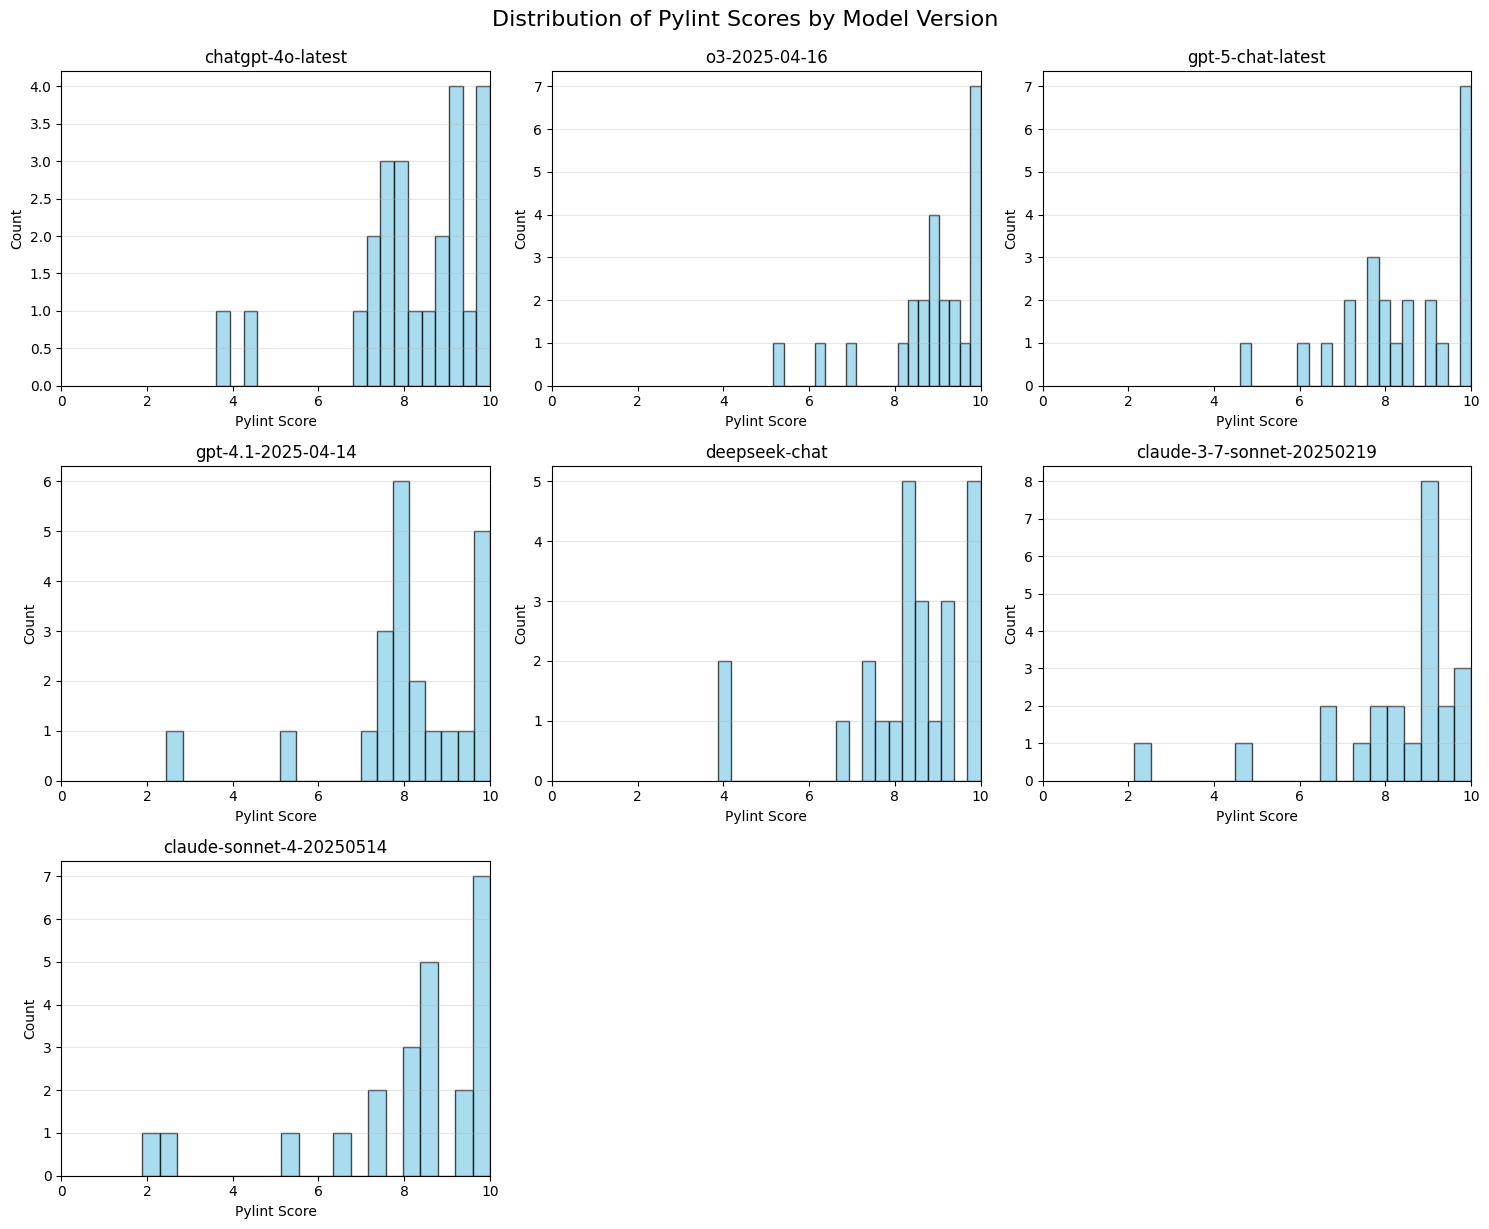

In [34]:
import matplotlib.pyplot as plt

# List of all models present in the data
n_models = len(models)

# Set up the subplot grid
n_cols = 3  # Adjust according to taste/number of models
n_rows = (n_models + n_cols - 1) // n_cols  # Ensure enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, model in enumerate(models):
    ax = axes[idx]
    data = agg_df[agg_df['model_version'] == model]['mean_pylint_score']
    ax.hist(data.dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f"{model}")
    ax.set_xlabel("Pylint Score")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 10)
    ax.grid(True, axis='y', alpha=0.3)

# Hide unused subplots if any
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle("Distribution of Pylint Scores by Model Version", fontsize=16, y=1.02)
plt.show()

## Correlate

In [31]:
import pandas as pd
from scipy.stats import pearsonr
import pingouin as pg
from statsmodels.stats.multitest import multipletests

# Set your column names:
code_quality_cols = [
    "mean_radon_complexity", "mean_radon_maintainability_index", "mean_radon_loc",
    "mean_radon_sloc", "mean_radon_lloc", "mean_radon_comments", "mean_pylint_score"
]
prompt_marker_cols = [
    "length_message_text_words", "length_conversational_words", "inv_inf", "informational", "involved", "maj_objectives_score", "maj_communication_score"
]

model_corrs = {}

for model, df_sub in agg_df.groupby("model_version"):
    results = []
    for cq in code_quality_cols:
        for pm in prompt_marker_cols:
            x = df_sub[pm]
            y = df_sub[cq]
            mask = x.notna() & y.notna()
            n = mask.sum()
            if n >= 3:
                corr, pval = pearsonr(x[mask], y[mask])
                ci = pg.compute_bootci(
                    x[mask].values,
                    y[mask].values,
                    func='pearson',
                    paired=True,
                    confidence=0.95,
                    n_boot=1000,
                    seed=42
                )
                ci_low, ci_high = ci
            else:
                corr, pval, ci_low, ci_high = (float('nan'), float('nan'), float('nan'), float('nan'))
            results.append({
                "code_quality_metric": cq,
                "prompt_marker": pm,
                "correlation": corr,
                "p_value": pval,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "model": model,
                "n": n,
            })
    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Apply Benjamini-Hochberg FDR correction to all non-NaN p-values
    valid_pvalues = df_results["p_value"].notna()
    pvals = df_results.loc[valid_pvalues, "p_value"].values

    # Only correct if there are any valid p-values
    if len(pvals) > 0:
        rejected, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
        # Insert the FDR-adjusted p-values into correct rows; fill others with NaN
        df_results['p_FDR'] = float('nan')
        df_results.loc[valid_pvalues, 'p_FDR'] = pvals_corr
    else:
        df_results['p_FDR'] = float('nan')

    model_corrs[model] = df_results

In [32]:
model_corrs['gpt-5-chat-latest']

,code_quality_metric,prompt_marker,correlation,p_value,ci_low,ci_high,model,n,p_FDR
0,mean_radon_complexity,length_message_text_words,0.196421,0.369043,-0.15,0.61,gpt-5-chat-latest,23,0.618781
1,mean_radon_complexity,length_conversational_words,0.417163,0.047655,-0.26,0.80,gpt-5-chat-latest,23,0.301457
2,mean_radon_complexity,inv_inf,-0.086263,0.695530,-0.47,0.28,gpt-5-chat-latest,23,0.792581
3,mean_radon_complexity,informational,-0.090474,0.681406,-0.37,0.33,gpt-5-chat-latest,23,0.792581
4,mean_radon_complexity,involved,-0.127650,0.561625,-0.47,0.31,gpt-5-chat-latest,23,0.724201
5,mean_radon_complexity,maj_objectives_score,0.138579,0.528308,-0.26,0.53,gpt-5-chat-latest,23,0.699651
6,mean_radon_complexity,maj_communication_score,-0.262642,0.225994,-0.64,0.17,gpt-5-chat-latest,23,0.534098
7,mean_radon_maintainability_index,length_message_text_words,-0.169926,0.438248,-0.77,0.18,gpt-5-chat-latest,23,0.631341
8,mean_radon_maintainability_index,length_conversational_words,-0.379827,0.073826,-0.66,0.00,gpt-5-chat-latest,23,0.301457
9,mean_radon_maintainability_index,inv_inf,0.436395,0.037357,0.08,0.67,gpt-5-chat-latest,23,0.301457


## Average Correlations across models

In [13]:
import pandas as pd
import numpy as np
import pingouin as pg

# model_corrs_dict: dictionary such that
#   key: model name/version (string)
#   value: dataframe with columns ['code_quality_metric', 'prompt_marker', 'correlation', 'p_value']

# 1. Stack all model DataFrames, tagging with model name/version
all_corrs = []
for model, df in model_corrs.items():
    temp = df.copy()
    temp['model'] = model
    all_corrs.append(temp)
all_corrs_df = pd.concat(all_corrs, axis=0, ignore_index=True)

# 2. Group and aggregate across models
def agg_ci(group):
    corrs = group['correlation'].values
    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs, ddof=1)
    boot = pg.compute_bootci(corrs, func='mean', n_boot=10000, seed=42)
    ci_low = np.percentile(boot, 2.5)
    ci_high = np.percentile(boot, 97.5)
    return pd.Series({
        'mean': mean_corr,
        'std': std_corr,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

agg_df = (
    all_corrs_df
    .groupby(['code_quality_metric', 'prompt_marker'])
    .apply(agg_ci)
    .reset_index()
)[['code_quality_metric', 'prompt_marker', 'mean', 'std', 'ci_low', 'ci_high']]

agg_df


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_5792/3963788881.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_ci)


,code_quality_metric,prompt_marker,mean,std,ci_low,ci_high
0,mean_pylint_score,informational,-0.104159,0.113992,-0.16625,-0.02375
1,mean_pylint_score,inv_inf,-0.022109,0.138578,-0.09525,0.08525
2,mean_pylint_score,involved,-0.091624,0.154808,-0.18475,0.01475
3,mean_pylint_score,length_conversational_words,-0.089950,0.152073,-0.18475,0.01475
4,mean_pylint_score,length_message_text_words,-0.246834,0.118505,-0.32600,-0.17400
5,mean_pylint_score,maj_communication_score,-0.023642,0.096803,-0.08675,0.03675
6,mean_pylint_score,maj_objectives_score,-0.135511,0.068967,-0.17775,-0.09225
7,mean_radon_comments,informational,0.270016,0.060696,0.23200,0.30800
8,mean_radon_comments,inv_inf,-0.175988,0.085939,-0.22700,-0.11300
9,mean_radon_comments,involved,-0.122317,0.068897,-0.16775,-0.08225


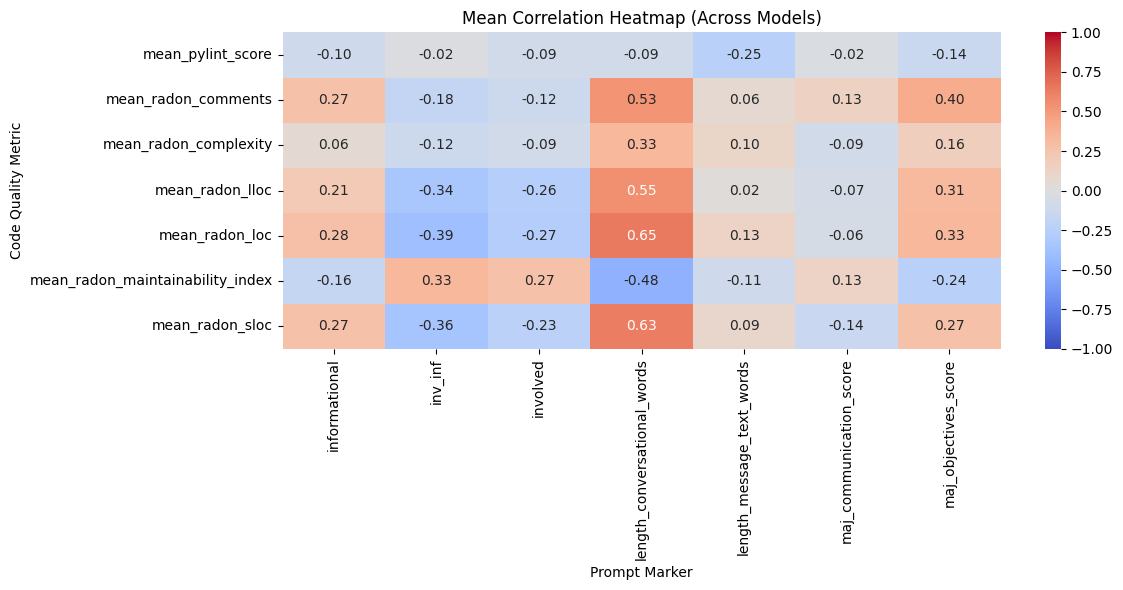

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose agg_df has columns: ['code_quality_metric', 'prompt_marker', 'mean', 'std', 'ci_low', 'ci_high']

# Pivot to matrix for heatmap (rows = code_quality_metric, columns = prompt_marker, values = mean corr)
heatmap_data = agg_df.pivot(index='code_quality_metric', columns='prompt_marker', values='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,       # show numbers in cells
    fmt=".2f",        # formatting for numbers
    cmap="coolwarm",  # color scheme, you can choose others
    vmin=-1, vmax=1   # set color limits for correlation
)
plt.title("Mean Correlation Heatmap (Across Models)")
plt.ylabel("Code Quality Metric")
plt.xlabel("Prompt Marker")
plt.tight_layout()
plt.show()

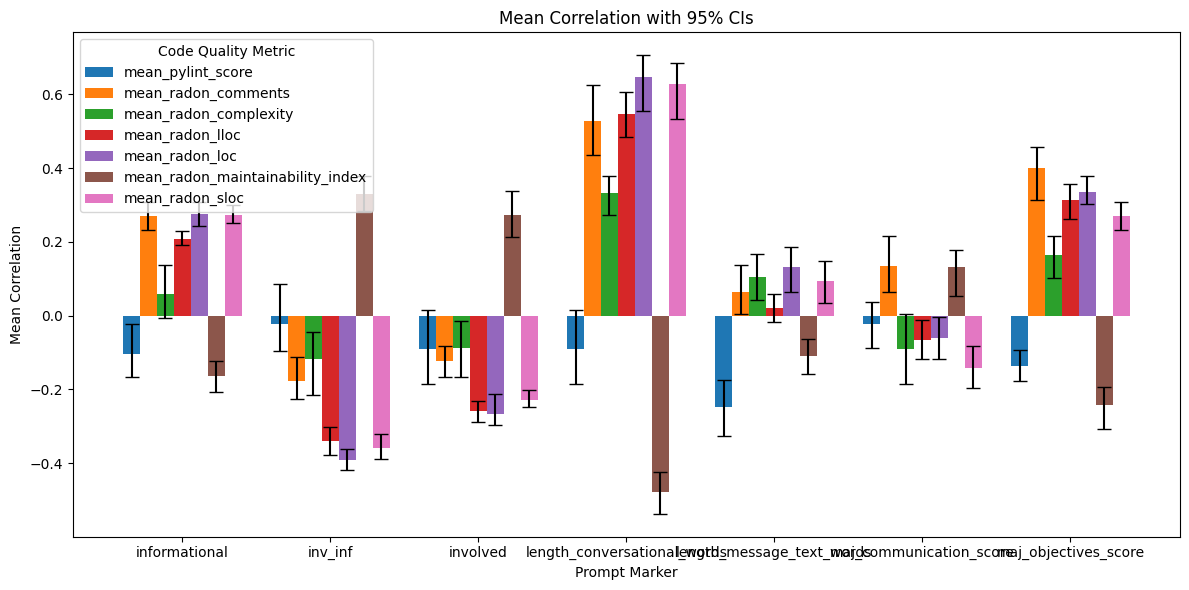

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample structure
markers = agg_df['prompt_marker'].unique()
metrics = agg_df['code_quality_metric'].unique()

bar_width = 0.8 / len(metrics)   # assume 0.8 is group width (to leave some spacing)

x = np.arange(len(markers))  # the group positions (center of each group)

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    group = agg_df[agg_df['code_quality_metric'] == metric]
    means = group.set_index('prompt_marker').loc[markers]['mean']
    ci_lows = group.set_index('prompt_marker').loc[markers]['ci_low']
    ci_highs = group.set_index('prompt_marker').loc[markers]['ci_high']
    errors = [means - ci_lows, ci_highs - means]
    # plotting the bars at right offset within group
    plt.bar(
        x + i * bar_width,
        means,
        width=bar_width,
        label=metric,
        yerr=errors,
        capsize=5
    )

plt.xticks(x + bar_width * (len(metrics)-1)/2, markers)
plt.xlabel("Prompt Marker")
plt.ylabel("Mean Correlation")
plt.legend(title="Code Quality Metric")
plt.title("Mean Correlation with 95% CIs")
plt.tight_layout()
plt.show()


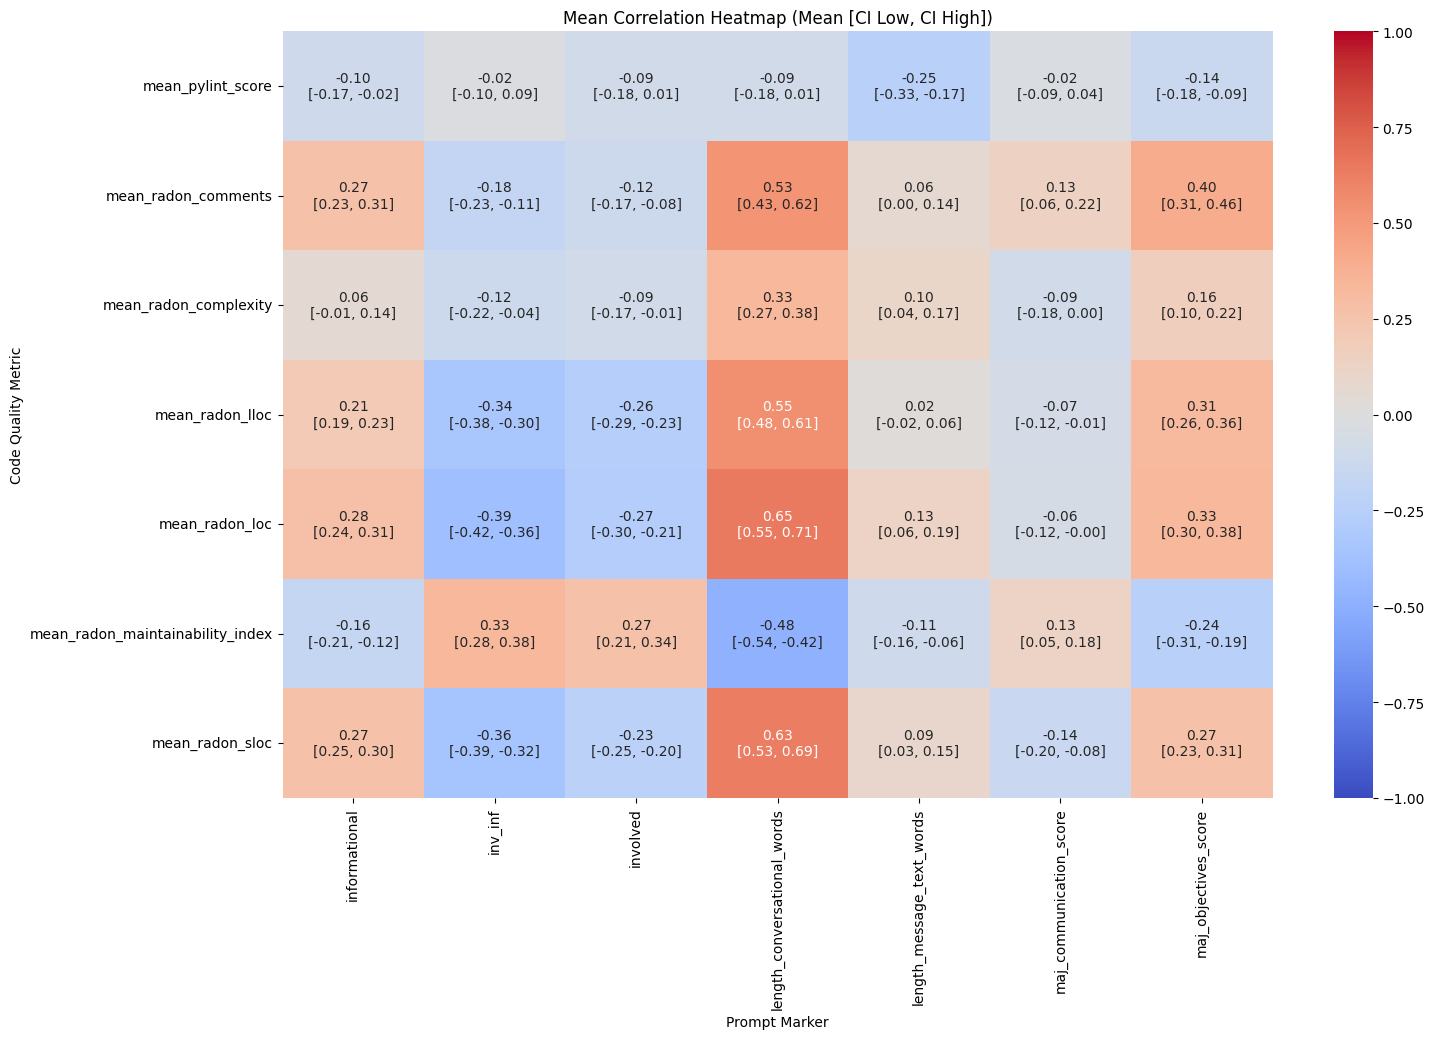

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose agg_df has columns: ['code_quality_metric', 'prompt_marker', 'mean', 'std', 'ci_low', 'ci_high']

# Pivot for each relevant value
heatmap_mean = agg_df.pivot(index='code_quality_metric', columns='prompt_marker', values='mean')
heatmap_low = agg_df.pivot(index='code_quality_metric', columns='prompt_marker', values='ci_low')
heatmap_high = agg_df.pivot(index='code_quality_metric', columns='prompt_marker', values='ci_high')

# Build annotation text with mean and CI in each cell
annot = heatmap_mean.copy().astype(str)
for i in heatmap_mean.index:
    for j in heatmap_mean.columns:
        m = heatmap_mean.loc[i, j]
        lo = heatmap_low.loc[i, j]
        hi = heatmap_high.loc[i, j]
        annot.loc[i, j] = f"{m:.2f}\n[{lo:.2f}, {hi:.2f}]"

plt.figure(figsize=(len(heatmap_mean.columns)*2.2, len(heatmap_mean.index)*1.5))
sns.heatmap(
    heatmap_mean,
    annot=annot,
    fmt='',
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot_kws={"size": 10}
)
plt.title("Mean Correlation Heatmap (Mean [CI Low, CI High])")
plt.ylabel("Code Quality Metric")
plt.xlabel("Prompt Marker")
plt.tight_layout()
plt.show()
